In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
df = pd.read_csv('ETH_TWEET_SENTIMENTS.csv')

In [3]:
df.head()

,Unnamed: 0,Text,likeCount,retweetCount,time,compound,pos,neg,neu,Twitter_Flair,Twitter_TB_Polarity,Twitter_TB_Subjectivity
0,0,@wealthytalkz @Virtualand_tech I understand th...,1.0,0.0,2022-01-01 23:59:35+00:00,0.5,0.1,0.0,0.934,-0.578022,-0.062500,0.437500
1,1,@mac_crypto25 @MatMan3331 @ogefellas @WhitneyW...,6.0,0.0,2022-01-01 23:59:20+00:00,1.0,0.2,0.0,0.760,0.951924,0.366667,0.266667
2,2,@benmcdonaghh @CGasparino @boxing101_gg @Rippl...,1.0,0.0,2022-01-01 23:58:57+00:00,0.5,0.1,0.0,0.856,0.918591,0.000000,0.000000
3,3,"✨I've just created ""Camaro SS"" collectible! \n...",3.0,0.0,2022-01-01 23:58:01+00:00,0.7,0.2,0.1,0.730,0.998577,0.187500,0.600000
4,4,That is my Jam🐝\n\n#M2ToTheMoon #Ethereum \n\n...,4.0,1.0,2022-01-01 23:57:32+00:00,0.0,0.0,0.0,1.000,0.864589,0.000000,0.000000


In [4]:
df.shape

(551940, 12)

In [5]:
df.dtypes

Unnamed: 0                   int64
Text                        object
likeCount                  float64
retweetCount               float64
time                        object
compound                   float64
pos                        float64
neg                        float64
neu                        float64
Twitter_Flair              float64
Twitter_TB_Polarity        float64
Twitter_TB_Subjectivity    float64
dtype: object

In [6]:
df1 = pd.read_excel('ETH_USDT.xlsx')

In [7]:
df1.dtypes

unix                    int64
date           datetime64[ns]
symbol                 object
open                  float64
high                  float64
low                   float64
close                 float64
Volume ETH            float64
Volume USDT           float64
tradecount              int64
dtype: object

In [8]:
df['date'] = pd.to_datetime(df['time'])

In [9]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df1.drop('unix',axis=1,inplace=True)
df1.drop('symbol',axis=1,inplace=True)
df.drop('Text',axis=1,inplace=True)
df.drop('time',axis=1,inplace=True)
#df.drop('Text',axis=1,inplace=True)

In [10]:
df['date'] = df['date'].dt.strftime('%y-%m-%d-%H')
df1['date'] = df1['date'].dt.strftime('%y-%m-%d-%H')

In [11]:
#merge = [df,df1]
#merge = pd.concat(merge)
merge = pd.merge(df,df1,on='date')

In [12]:
merge.set_index('date',inplace=True)

In [13]:
merge.sort_values(by='date',inplace=True)

In [14]:
merge.head()

,likeCount,retweetCount,compound,pos,neg,neu,Twitter_Flair,Twitter_TB_Polarity,Twitter_TB_Subjectivity,open,high,low,close,Volume ETH,Volume USDT,tradecount
date,,,,,,,,,,,,,,,,
22-01-01-00,8.0,3.0,0.7,0.1,0.0,0.884,-0.713887,0.242614,0.396136,3676.22,3730.0,3676.22,3723.04,9023.374,3.343005e+07,21702
22-01-01-00,5.0,2.0,0.7,0.2,0.0,0.759,0.994924,0.000000,0.000000,3676.22,3730.0,3676.22,3723.04,9023.374,3.343005e+07,21702
22-01-01-00,3.0,0.0,-0.4,0.0,0.1,0.915,-0.998124,0.500000,0.500000,3676.22,3730.0,3676.22,3723.04,9023.374,3.343005e+07,21702
22-01-01-00,2.0,0.0,0.2,0.1,0.0,0.893,0.982312,0.258333,0.350000,3676.22,3730.0,3676.22,3723.04,9023.374,3.343005e+07,21702
22-01-01-00,4.0,0.0,0.0,0.0,0.0,1.000,0.797964,0.000000,0.000000,3676.22,3730.0,3676.22,3723.04,9023.374,3.343005e+07,21702


In [18]:
dataset = merge.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(merge)
print('dataset.shape', dataset.shape)
num_of_features = len(merge.columns)
print('Number of features', num_of_features)

dataset.shape (551940, 16)
Number of features 16


In [19]:
expr_name = 'expr_4'
look_back = 24*7 
#lstm_layers = 50
epochs=5
batch_size=128

In [20]:
train_size_percent = 0.70
pred_col = merge.columns.get_loc('close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  386358
Testing dataset length  165582
look_back  168


In [21]:
model = Sequential()
model.add(LSTM(32,input_shape=(look_back,num_of_features)))
#model.add(LSTM(100,activation='relu',return_sequences=True))
#model.add(LSTM(50,activation='relu',return_sequences=True))
#model.add(LSTM(25,activation='relu'))
#model.add(LSTM(20,activation='relu'))
#model.add(LSTM(10,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.35, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
1962/1962 [==============================] - 393s 196ms/step - loss: 0.0012 - val_loss: 0.0167
Epoch 2/5
1962/1962 [==============================] - 813s 414ms/step - loss: 6.6282e-04 - val_loss: 0.0148
Epoch 3/5
1962/1962 [==============================] - 1030s 525ms/step - loss: 9.0519e-04 - val_loss: 0.0146
Epoch 4/5
1962/1962 [==============================] - 999s 509ms/step - loss: 0.0011 - val_loss: 0.0139
Epoch 5/5
1962/1962 [==============================] - 1045s 533ms/step - loss: 0.0012 - val_loss: 0.0127


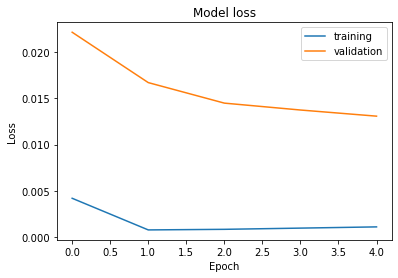

In [20]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [21]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

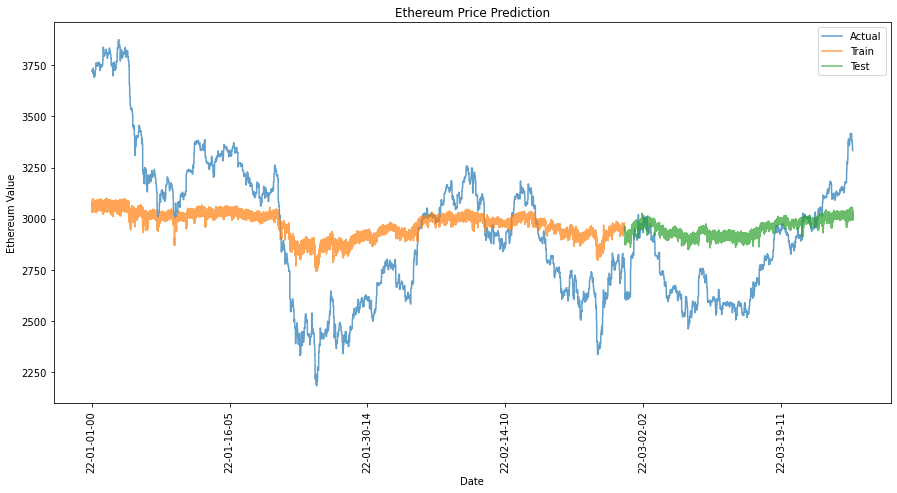

In [22]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(merge.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=True)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Ethereum Value')
plt.title('Ethereum Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [24]:
print('-' * 100)
print('Experiment name:', expr_name)

print('-' * 100)
print('look_back days:', look_back/24)
#print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(merge.columns))


print('-' * 100)
print('Train Score: RMSE: ',(trainScore_RMSE))
print('Test Score: RMSE: ',(testScore_RMSE))

print('-' * 100)
print('Train Score: MAE: ',(trainScore_MAE))
print('Test Score: MAE: ',(testScore_MAE))
print('-' * 100)
print('Model summary:')
model.summary()

----------------------------------------------------------------------------------------------------
Experiment name: expr_4
----------------------------------------------------------------------------------------------------
look_back days: 7.0
epochs: 5
batch_size: 128
dataset features ['likeCount', 'retweetCount', 'compound', 'pos', 'neg', 'neu', 'Twitter_Flair', 'Twitter_TB_Polarity', 'Twitter_TB_Subjectivity', 'date']
----------------------------------------------------------------------------------------------------
Train Score: RMSE:  310.4340963790598
Test Score: RMSE:  229.26854348442203
----------------------------------------------------------------------------------------------------
Train Score: MAE:  253.02065510538597
Test Score: MAE:  192.60966499293698
----------------------------------------------------------------------------------------------------
Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)     